In [ ]:
# Copyright (C) 2023 Elif Cansu YILDIZ
# 
# This program is free software; you can redistribute it and/or modify it under
# the terms of the GNU General Public License as published by the Free Software
# Foundation; either version 3 of the License, or (at your option) any later
# version.
# 
# This program is distributed in the hope that it will be useful, but WITHOUT
# ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS
# FOR A PARTICULAR PURPOSE. See the GNU General Public License for more
# details.
# 
# You should have received a copy of the GNU General Public License along with
# this program; if not, see <http://www.gnu.org/licenses/>.

In [ ]:
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Rectangle
import matplotlib.pyplot as plt

import medai.config as config
from medai.data.loader import ChestDataModule
from medai.data.datasets import ChestXDetDataset
from medai.utils.transforms import ChexNetAugmentation,ChexNetAugmentationMultiImages, Resize
import medai.utils.eval_utils as eval_utils
import medai.utils.heatmaps as heatmaps
import medai.models.SASN_vanilla as sasn_vanilla
import medai.models.SASN_split as sasn_split
import medai.models.chexnet as chexnet
import medai.models.maskrcnn as maskrcnn

%load_ext autoreload
%autoreload 2

In [2]:
config_file = "sasn_config.yaml"
config_file_path = os.path.join(config.CONFIG_DIR, config_file)
with open(config_file_path, "r") as stream:
    params = yaml.safe_load(stream)

params["dataloader"]["batch_size"] = 1
params["dataset"]["train"]["transform"] = None

sasn_data_module = ChestDataModule(dataset_class=ChestXDetDataset, **params["dataloader"])
sasn_data_module.setup("fit", **params["dataset"]["train"])
sasn_data_module.setup("test", **params["dataset"]["test"])
    
#####################################################################

config_file = "chexnet_config.yaml"
config_file_path = os.path.join(config.CONFIG_DIR, config_file)
with open(config_file_path, "r") as stream:
    params = yaml.safe_load(stream)

params["dataloader"]["batch_size"] = 1
if params["dataset"]["train"]["transform"] is not None:
    params["dataset"]["train"]["transform"] = ChexNetAugmentationMultiImages(flip_randomness=0.0)
if params["dataset"]["test"]["transform"] is not None:
    params["dataset"]["test"]["transform"] = ChexNetAugmentationMultiImages(flip_randomness=0.0)

chexnet_data_module = ChestDataModule(dataset_class=ChestXDetDataset, **params["dataloader"])
chexnet_data_module.setup(stage="fit", **params["dataset"]["train"])
chexnet_data_module.setup(stage="test", **params["dataset"]["test"])

######################################################################

config_file = "maskrcnn_config.yaml"
config_file_path = os.path.join(config.CONFIG_DIR, config_file)
with open(config_file_path, "r") as stream:
    params = yaml.safe_load(stream)

params["dataloader"]["batch_size"] = 1

maskrcnn_data_module = ChestDataModule(dataset_class=ChestXDetDataset, **params["dataloader"])
maskrcnn_data_module.setup("fit", **params["dataset"]["train"])
maskrcnn_data_module.setup("test", **params["dataset"]["test"])

In [ ]:
SASN_vanilla_model_path= os.path.join(config.BASE_DIR, "logs/SASN_vanilla/2023-03-14_16-53-56/version_0/checkpoints/epoch=299-step=51000.ckpt")
SASN_split_model_path= os.path.join(config.BASE_DIR, "logs/SASN_split/2023-03-15_13-28-33/version_0/checkpoints/epoch=299-step=51000.ckpt")
CheXNet_model_path= os.path.join(config.BASE_DIR, "logs/DenseNet_model/2023-03-16_00-55-50/version_0/checkpoints/epoch=299-step=3300.ckpt")
MaskRCNN_model_path= os.path.join(config.BASE_DIR, "logs/MaskRCNN/2023-03-22_23-50-09/version_0/checkpoints/epoch=299-step=41100.ckpt")

SASN_vanilla_model = eval_utils.load_model(model=sasn_vanilla.SiameseNetwork(), path=SASN_vanilla_model_path)
SASN_split_model = eval_utils.load_model(model=sasn_split.SiameseNetwork(), path=SASN_split_model_path)
CheXNet_model = eval_utils.load_chexnet_model(model=chexnet.DenseNet(), path=CheXNet_model_path)
MaskRCNN_model = eval_utils.load_model(model=maskrcnn.MaskRCNN(box_score_thresh=0.5), path=MaskRCNN_model_path)

In [5]:
sample_ids = {2,5,15,37,42,45} #{2,13,15,37,42} #{2,5,15,37,42}
images, polygon_labels = heatmaps.get_images_polygon_labels(sasn_data_module.test_dataset, sample_range=(0,48), sample_set=sample_ids)

sasn_vanilla_test_iter = iter(sasn_data_module.test_dataloader)
sasn_vanilla_prob_heatmaps, sasn_vanilla_distance_maps = heatmaps.get_SASN_vanilla_heatmaps(SASN_vanilla_model, sasn_vanilla_test_iter, num_images=48, to_overlay=True, sample_set=sample_ids)

sasn_split_test_iter = iter(sasn_data_module.test_dataloader)
sasn_split_prob_heatmaps, sasn_split_distance_maps = heatmaps.get_SASN_split_heatmaps(SASN_split_model, sasn_split_test_iter, num_images=48, to_overlay=True, sample_set=sample_ids)

chexnet_test_iter = iter(chexnet_data_module.test_dataloader)
chexnet_heatmaps = heatmaps.get_CheXNet_heatmaps(CheXNet_model, chexnet_test_iter, num_images=48, sample_set=sample_ids)

maskrcnn_test_iter = iter(maskrcnn_data_module.test_dataloader)
maskrcnn_heatmaps, maskrcnn_boxes = heatmaps.get_MaskRCNN_heatmaps(MaskRCNN_model, maskrcnn_test_iter, num_images=48, print_scores=False, sample_set=sample_ids)

2 5 15 37 42 45 i:  2 i:  5 i:  15 i:  37 i:  42 i:  45 i:  2 i:  5 i:  15 i:  37 i:  42 i:  45 i:  2 i:  5 i:  15 i:  37 i:  42 i:  45 i:  2 i:  5 i:  15 i:  37 i:  42 i:  45 

### Visualization with Overlays

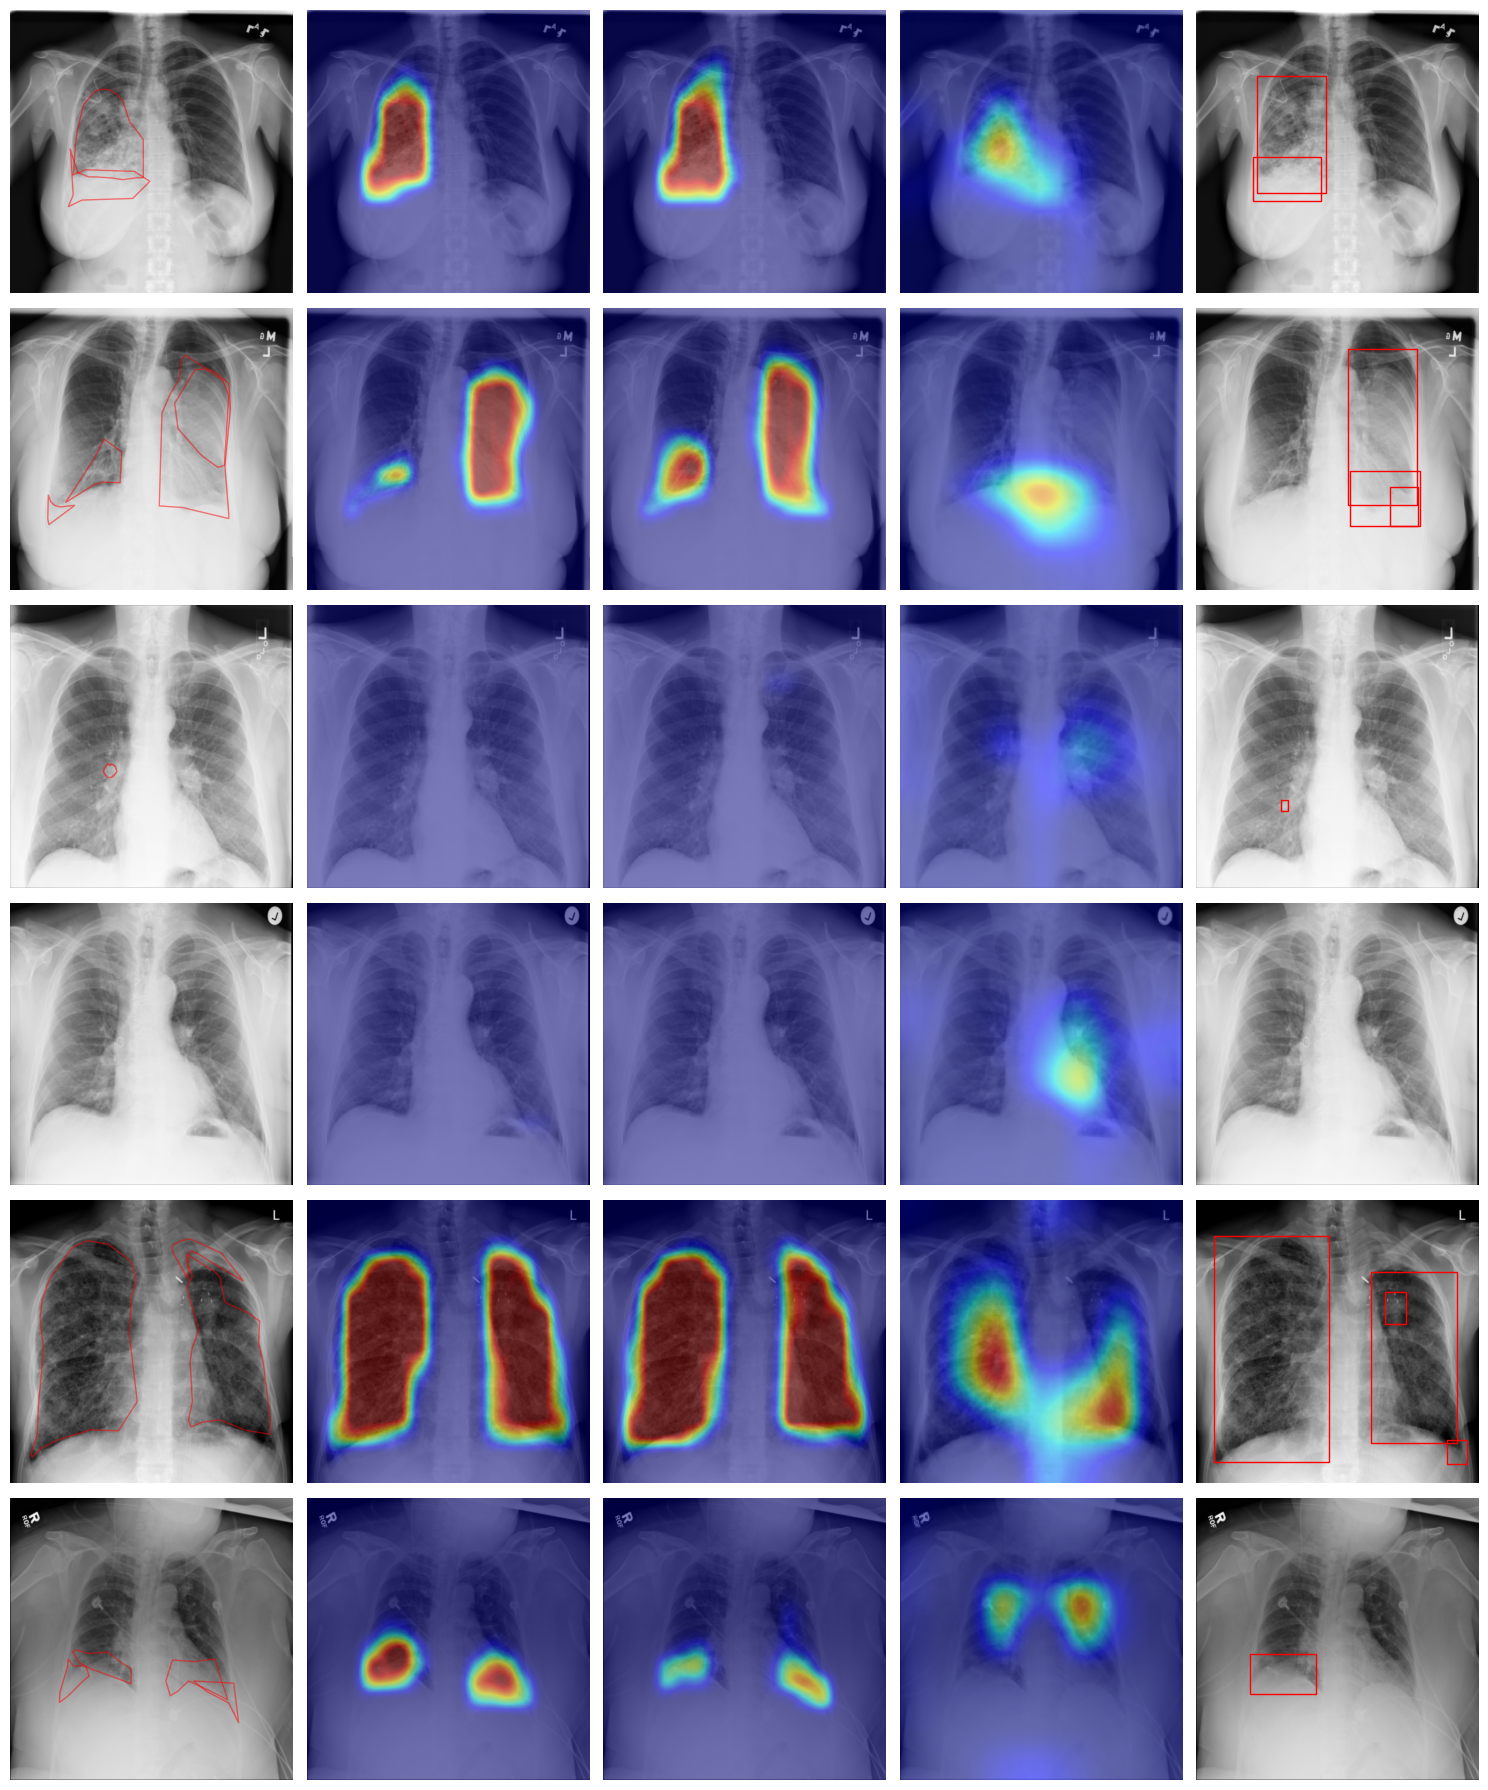

In [74]:
num_images = 6
fig, axs = plt.subplots(num_images, 5, figsize=(15, num_images*3))

sample_ids = [2, 4, 0, 1, 3, 5]

for i, idx in enumerate(sample_ids):
    
    axs[i][0].imshow(images[idx].permute(1,2,0)); axs[i][0].axis("off")
    for polygon in polygon_labels[idx]:
        p = Polygon(np.array(polygon), fill=False, color="red", alpha=0.5)
        axs[i][0].add_patch(p)
    
    axs[i][1].imshow(sasn_vanilla_prob_heatmaps[idx].permute(1,2,0)); axs[i][1].axis("off")
    axs[i][2].imshow(sasn_split_prob_heatmaps[idx].permute(1,2,0)); axs[i][2].axis("off")
    axs[i][3].imshow(chexnet_heatmaps[idx].permute(1,2,0), vmin=0, vmax=1); axs[i][3].axis("off")
    
    axs[i][4].imshow(images[idx].permute(1,2,0)); axs[i][4].axis("off")
    for idx, bbox in enumerate(maskrcnn_boxes[idx]):
        x1,y1,x2,y2 = bbox
        axs[i][4].add_patch(Rectangle( xy=(x1,y1), width=x2-x1, height=y2-y1, fill=False, color="red" ))
    
plt.tight_layout()

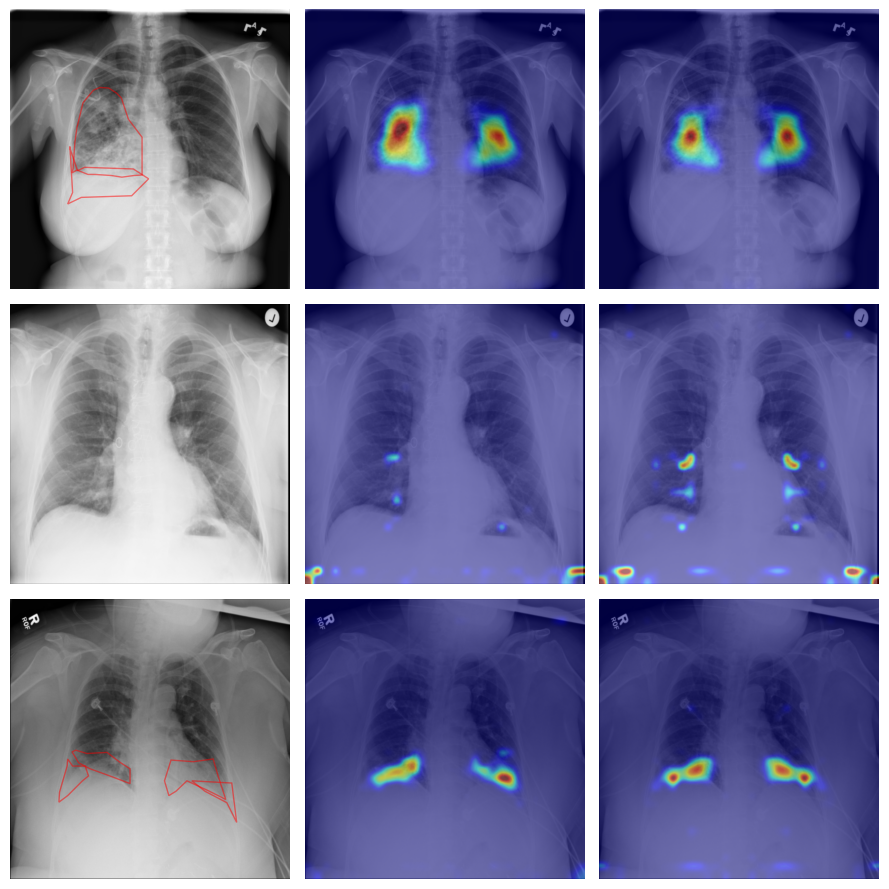

In [76]:
#sample_ids = [2, 4, 0, 1, 3, 5]
sample_ids = [2, 1, 5]
num_images = len(sample_ids)

"""
fig, axs = plt.subplots(num_images, 5, figsize=(15, num_images*3))

for idx, s_id in enumerate(sample_ids):
    axs[idx][0].imshow(images[s_id].permute(1,2,0)); axs[idx][0].axis('off')
    for polygon in polygon_labels[s_id]:
        p = Polygon(np.array(polygon), fill=False, color="red", alpha=0.5)
        axs[idx][0].add_patch(p)
    axs[idx][1].imshow(sasn_vanilla_prob_heatmaps[s_id].permute(1,2,0), vmin=0.0, vmax=1.0); axs[idx][1].axis('off')
    axs[idx][2].imshow(sasn_vanilla_distance_maps[s_id].permute(1,2,0), vmin=0.0, vmax=1.0); axs[idx][2].axis('off')
    axs[idx][3].imshow(sasn_split_prob_heatmaps[s_id].permute(1,2,0), vmin=0.0, vmax=1.0); axs[idx][3].axis('off')
    axs[idx][4].imshow(sasn_split_distance_maps[s_id].permute(1,2,0), vmin=0.0, vmax=1.0); axs[idx][4].axis('off')
    
plt.tight_layout()
"""
fig, axs = plt.subplots(num_images, 3, figsize=(9, num_images*3))

for idx, s_id in enumerate(sample_ids):
    axs[idx][0].imshow(images[s_id].permute(1,2,0)); axs[idx][0].axis('off')
    for polygon in polygon_labels[s_id]:
        p = Polygon(np.array(polygon), fill=False, color="red", alpha=0.5)
        axs[idx][0].add_patch(p)
    axs[idx][1].imshow(sasn_vanilla_distance_maps[s_id].permute(1,2,0), vmin=0.0, vmax=1.0); axs[idx][1].axis('off')
    axs[idx][2].imshow(sasn_split_distance_maps[s_id].permute(1,2,0), vmin=0.0, vmax=1.0); axs[idx][2].axis('off')
    
plt.tight_layout()

### Visualization Without Overlays

i:  2 i:  5 i:  15 i:  37 i:  42 i:  2 i:  5 i:  15 i:  37 i:  42 

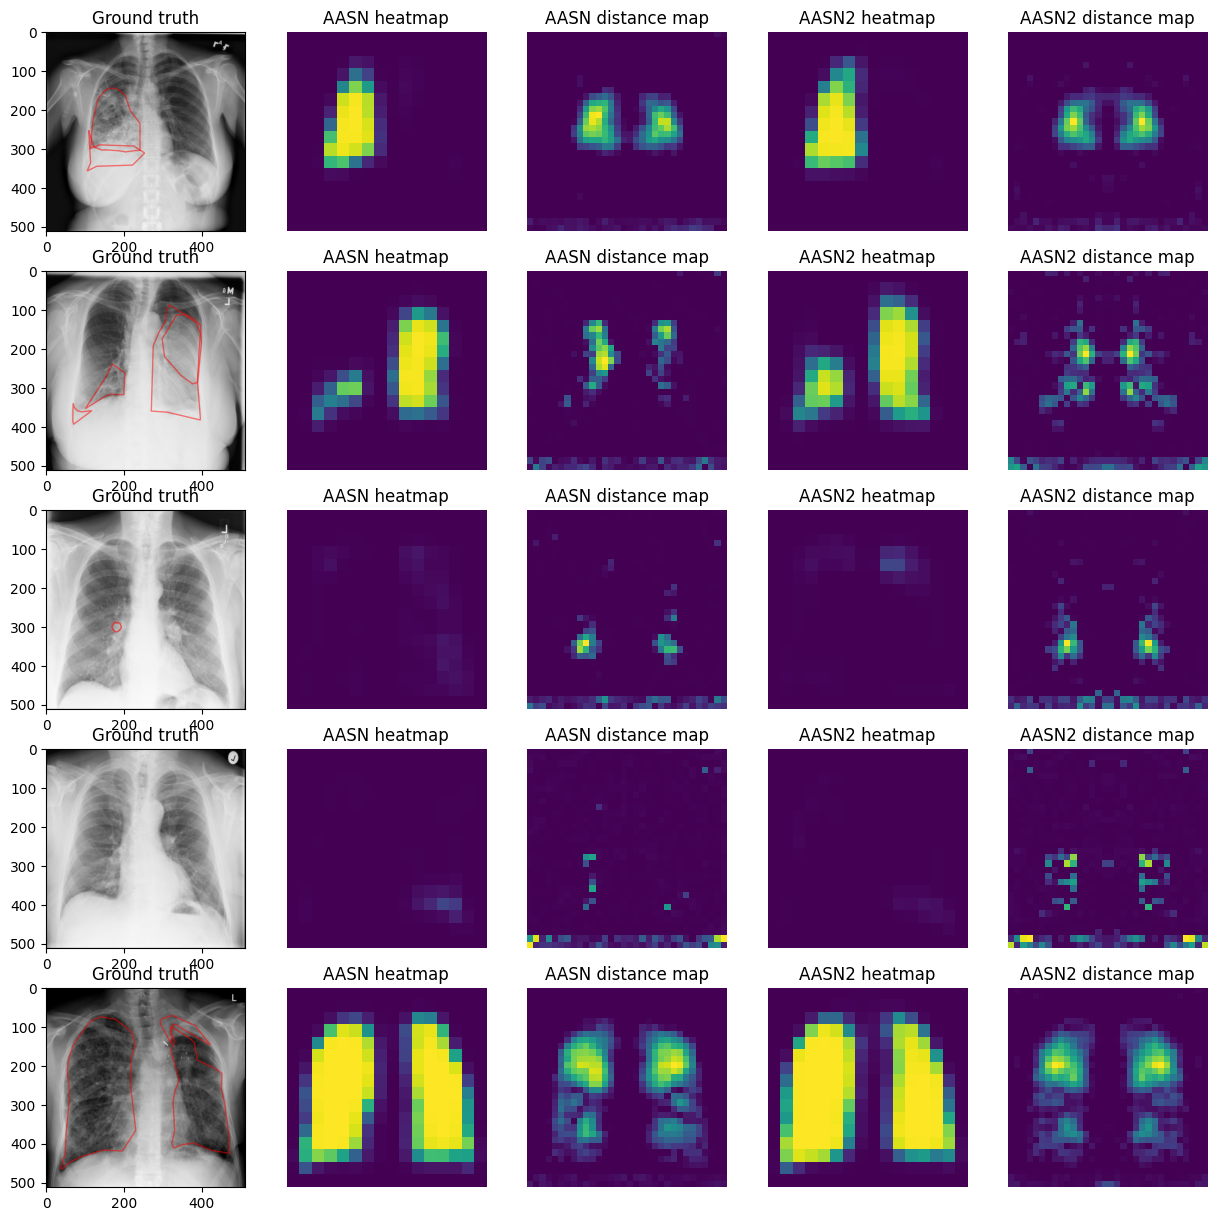

In [17]:
sasn_vanilla_test_iter = iter(sasn_data_module.test_dataloader)
sasn_vanilla_prob_heatmaps2, sasn_vanilla_distance_maps2 = heatmaps.get_SASN_vanilla_heatmaps(SASN_vanilla_model, sasn_vanilla_test_iter, num_images=48, to_overlay=False, sample_set={2,5,15,37,42})

sasn_split_test_iter = iter(sasn_data_module.test_dataloader)
sasn_split_prob_heatmaps2, sasn_split_distance_maps2 = heatmaps.get_SASN_split_heatmaps(SASN_split_model, sasn_split_test_iter, num_images=48, to_overlay=False, sample_set={2,5,15,37,42})

sample_ids = [2, 4, 0, 1, 3]
num_images = len(sample_ids)

fig, axs = plt.subplots(num_images, 5, figsize=(15, num_images*3))

for idx, s_id in enumerate(sample_ids):
    axs[idx][0].imshow(images[s_id].permute(1,2,0)); axs[idx][0].set_title("Ground truth")
    for polygon in polygon_labels[s_id]:
        p = Polygon(np.array(polygon), fill=False, color="red", alpha=0.5)
        axs[idx][0].add_patch(p)
    axs[idx][1].imshow(sasn_vanilla_prob_heatmaps2[s_id][0].permute(1,2,0), vmin=0.0, vmax=1.0); axs[idx][1].set_title("SASN_vanilla heatmap"); axs[idx][1].axis('off')
    axs[idx][2].imshow(sasn_vanilla_distance_maps2[s_id][0]); axs[idx][2].set_title("SASN_vanilla distance map"); axs[idx][2].axis('off')
    axs[idx][3].imshow(sasn_split_prob_heatmaps2[s_id][0].permute(1,2,0), vmin=0.0, vmax=1.0); axs[idx][3].set_title("SASN_split heatmap"); axs[idx][3].axis('off')
    axs[idx][4].imshow(sasn_split_distance_maps2[s_id][0]); axs[idx][4].set_title("SASN_split distance map"); axs[idx][4].axis('off')

### Saving each figure separately for selected images

In [ ]:
sample_ids = [2, 4, 0, 1, 3, 5]

for i, idx in enumerate(sample_ids):
    
    fig, axs = plt.subplots(1, 1)
    _ = axs.imshow(images[idx].permute(1,2,0)); axs.axis("off")
    for polygon in polygon_labels[idx]:
        p = Polygon(np.array(polygon), fill=False, color="red", alpha=0.5)
        axs.add_patch(p)
    plt.savefig(f"paper_images/gt_{i}.png", bbox_inches='tight')
    
    fig, axs = plt.subplots(1, 1)
    _ = axs.imshow(sasn_vanilla_prob_heatmaps[idx].permute(1,2,0)); axs.axis("off")
    plt.savefig(f"paper_images/SASN_vanilla_{i}.png", bbox_inches='tight')
    
    fig, axs = plt.subplots(1, 1)
    _ = axs.imshow(sasn_split_prob_heatmaps[idx].permute(1,2,0)); axs.axis("off")
    plt.savefig(f"paper_images/SASN_split_{i}.png", bbox_inches='tight')
    
    fig, axs = plt.subplots(1, 1)
    _ = axs.imshow(chexnet_heatmaps[idx].permute(1,2,0), vmin=0, vmax=1); axs.axis("off")
    plt.savefig(f"paper_images/CheXNet_{i}.png", bbox_inches='tight')
    
    fig, axs = plt.subplots(1, 1)
    _ = axs.imshow(images[idx].permute(1,2,0)); axs.axis("off")
    for idx, bbox in enumerate(maskrcnn_boxes[idx]):
        x1,y1,x2,y2 = bbox
        axs.add_patch(Rectangle( xy=(x1,y1), width=x2-x1, height=y2-y1, fill=False, color="red" ))
    plt.savefig(f"paper_images/MaskRCNN_{i}.png", bbox_inches='tight')

In [ ]:
sample_ids = [2, 1, 5]

for i, idx in enumerate(sample_ids):
    
    fig, axs = plt.subplots(1, 1)
    _ = axs.imshow(sasn_vanilla_distance_maps[idx].permute(1,2,0), vmin=0.0, vmax=1.0); axs.axis('off')
    plt.savefig(f"paper_images/SASN_vanilla_distmaps_{i}.png", bbox_inches='tight')

    fig, axs = plt.subplots(1, 1)
    _ = axs.imshow(sasn_split_distance_maps[idx].permute(1,2,0), vmin=0.0, vmax=1.0); axs.axis('off')
    plt.savefig(f"paper_images/SASN_split_distmaps_{i}.png", bbox_inches='tight')